In [2]:
import sys
sys.path.append('../')

from samrfi import RFITraining, SyntheticRFI

/home/gpuhost001/ddeal/miniconda3/envs/rfi-ai-gpuhost001/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [4]:

dir_path = '/home/gpuhost001/ddeal/RFI-AI/'

synthetic_rfi = SyntheticRFI(min_freq=0, max_freq=256*4, min_time=0, max_time=256*4, points_freq=256*4, points_time=256*4,)

spectrographs = []
models = []

for i in range(300):
    synthetic_rfi = SyntheticRFI(min_freq=0, max_freq=256*4, min_time=0, max_time=256*4, points_freq=256*4, points_time=256*4,)
    synthetic_rfi.generate_waterfall(pers_freq_gauss=2, pers_time_gauss=2, pers_freq_square=2, pers_time_square=2,  
                                    inter_freq_square=2, inter_freq_gauss=2, noise=np.random.randint(1,10), mean=np.random.randint(3,20), mean_rfi=1000, std_rfi=500, edge_buffer=10)
    synthetic_rfi.create_model_spectrograph()
    spectrographs.append(synthetic_rfi.spectrograph)
    stat = stats.median_abs_deviation(synthetic_rfi.spectrograph, axis=None)
    median = np.median(synthetic_rfi.spectrograph)
    models.append(synthetic_rfi.model_spectrograph>(median*.1 + (stat * .2)))

spectrographs_stack = np.stack(spectrographs, axis=0)
models_stack = np.stack(models, axis=0)

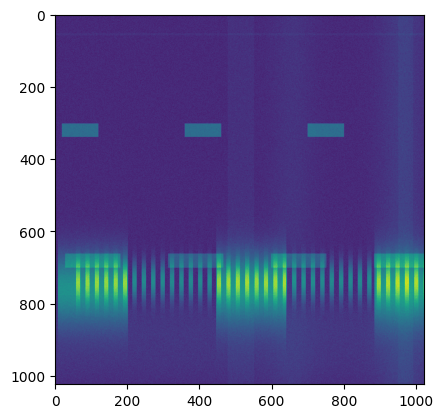

In [10]:
plt.imshow(spectrographs[0])

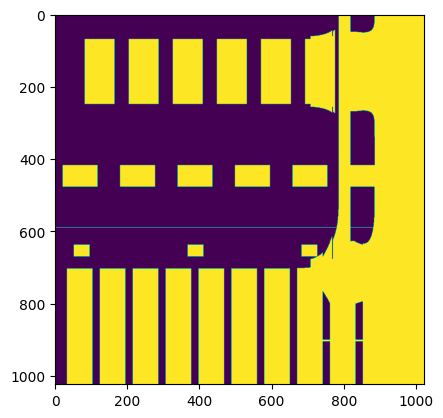

In [188]:
plt.imshow(models[10])

In [4]:
synthetic_rfi.model_spectrograph

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [190]:
rfi_combined = []

rfi_combined_flags = []

for baseline in spectrographs_stack:
        rfi_combined.append(baseline)
        rfi_combined.append(baseline.T)

for baseline in models_stack:
        rfi_combined_flags.append(baseline)
        rfi_combined_flags.append(baseline.T)

In [191]:
from tqdm import tqdm

rfi_combined_median = []

for data in tqdm(rfi_combined):

    data = data/np.median(data)

    rfi_combined_median.append(data)

100%|██████████| 200/200 [00:05<00:00, 35.16it/s]


In [192]:
from patchify import patchify

In [193]:
patch_size = 256
step = 256

all_img_patches = []
for img in rfi_combined_median:
    large_image = img
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in rfi_combined_flags:
    large_mask = img
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [194]:
filtered_flags = [arr for arr in masks if arr.any()]

In [195]:
# Create a mask indicating which arrays contain only False values
mask = [not arr.any() for arr in masks]

# Initialize an empty list to store the filtered arrays
filtered_images = []

# Iterate over the arrays and their corresponding mask values
for arr, m in zip(images, mask):
    # If the mask value is False, add the array to the filtered list
    if not m:
        filtered_images.append(arr)

In [196]:
# Generate a permutation of indices
filtered_images = np.stack(filtered_images)
filtered_flags = np.stack(filtered_flags)

indices = np.random.permutation(filtered_images.shape[0])

# Shuffle both arrays using the same indices
filtered_images = filtered_images[indices]
filtered_flags = filtered_flags[indices]

# Verify the shapes remain the same
print(filtered_images.shape)  # Should print (100, 64, 64)
print(filtered_flags.shape)  #

(3134, 256, 256)
(3134, 256, 256)


In [197]:
np.stack(filtered_images).shape

(3134, 256, 256)

In [198]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [199]:
from torch.utils.data import Dataset
from torchvision import transforms

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor
    # self.resize_transform = transforms.Compose([
    # transforms.Resize((2000, 2000)),
    # # Add other transformations here if necessary
    # ])

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    
    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)
    # input_pointsa = get_peak_points(real_array)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]],return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [200]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [201]:
from datasets import Dataset
from PIL import Image
filtered_images = filtered_images[0:600]
filtered_flags = filtered_flags[0:600]
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_flags],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

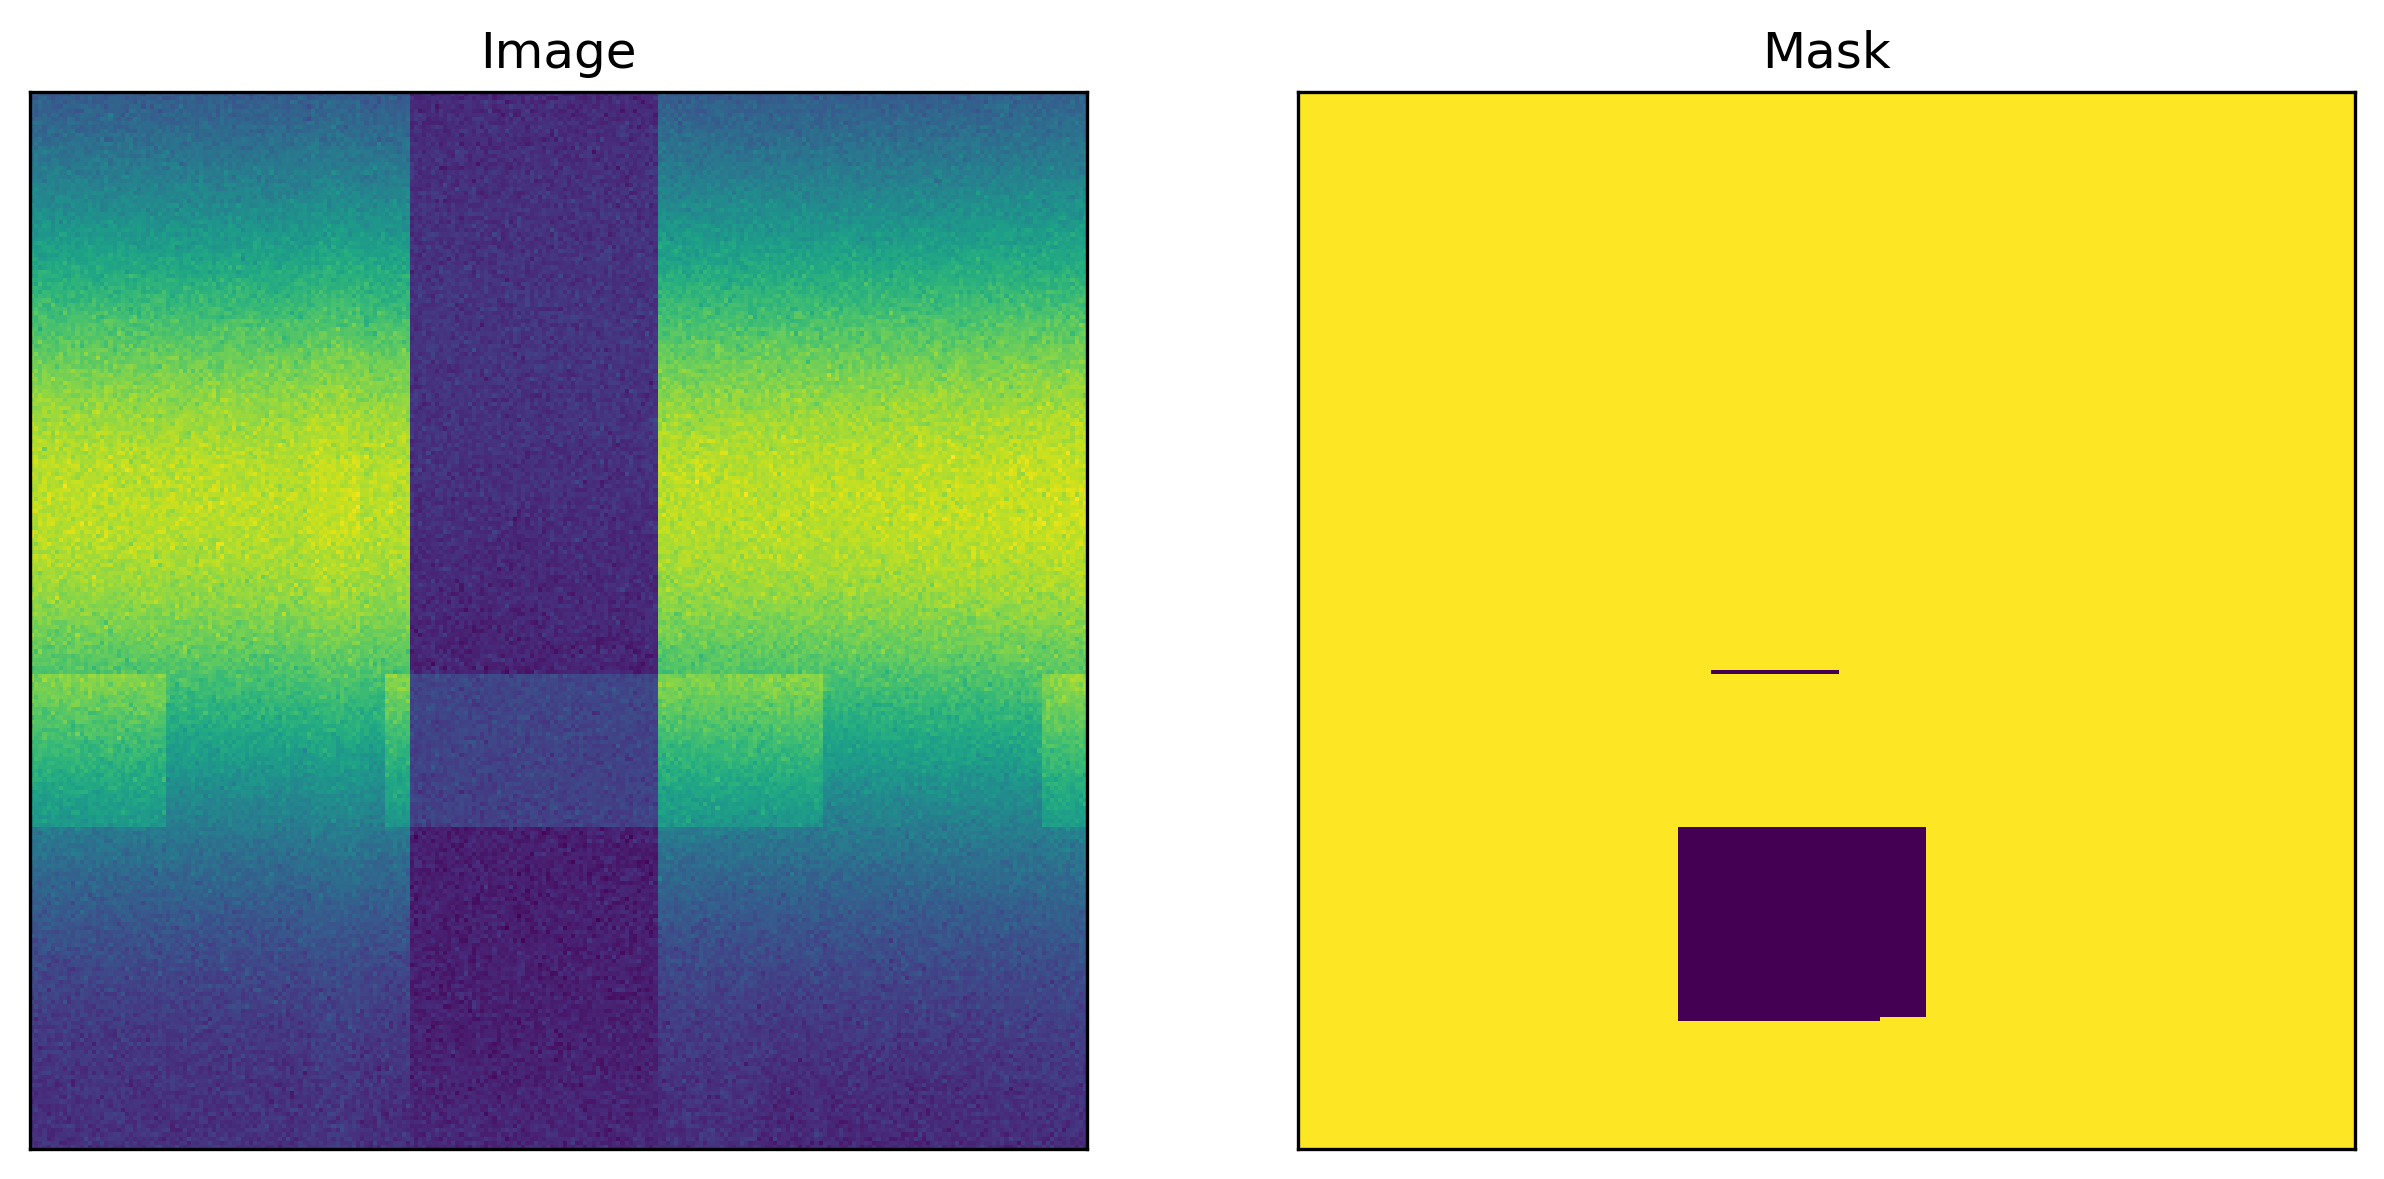

In [217]:
img_num = np.random.randint(0, 150-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

# Plot the first image on the left
axes[0].imshow(np.array(example_image).T,)  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(np.array(example_mask).T,)  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [218]:
# Initialize the processor
from transformers import SamProcessor
from torch.utils.data import DataLoader
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [219]:
# Reshape the images in the dataset to have a channel dimension
dataset_dict["image"] = [img.convert("RGB") for img in dataset_dict["image"]]

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# Create a new train_dataset with the updated dataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# Create a new train_dataloader with the updated train_dataset
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True,)


In [220]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)
pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


In [221]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-huge")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [222]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [223]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize, interpolate

In [224]:
# Training loop
ave_meanloss = []
num_epochs = 70

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

model.train()

for epoch in range(num_epochs):
    
    epoch_losses = []

    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        # Ensure ground truth masks are resized to match the predicted masks
        if len(ground_truth_masks.shape) == 3:  # Add channel dimension if missing
            ground_truth_masks = ground_truth_masks.unsqueeze(1)

        predicted_mask_size = predicted_masks.shape[-2:]  # Get the height and width of the predicted masks
        ground_truth_masks_resized = interpolate(ground_truth_masks, size=predicted_mask_size, mode='bilinear', align_corners=False)

        loss = seg_loss(predicted_masks, ground_truth_masks_resized)

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    ave_meanloss.append(mean(epoch_losses))

100%|██████████| 38/38 [02:34<00:00,  4.06s/it]


EPOCH: 0
Mean loss: 1.2783789948413247


100%|██████████| 38/38 [02:44<00:00,  4.32s/it]


EPOCH: 1
Mean loss: 0.9182143478017104


100%|██████████| 38/38 [03:07<00:00,  4.92s/it]


EPOCH: 2
Mean loss: 0.8684760834041395


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 3
Mean loss: 0.8431953795646366


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 4
Mean loss: 0.8133139720088557


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 5
Mean loss: 0.7910252135050925


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 6
Mean loss: 0.7688246181136683


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 7
Mean loss: 0.7569455582844583


100%|██████████| 38/38 [03:13<00:00,  5.10s/it]


EPOCH: 8
Mean loss: 0.7367204741427773


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 9
Mean loss: 0.7389122969225833


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 10
Mean loss: 0.7296073421051628


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 11
Mean loss: 0.7128446149198633


100%|██████████| 38/38 [03:13<00:00,  5.10s/it]


EPOCH: 12
Mean loss: 0.7072489630234869


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 13
Mean loss: 0.7010105424805692


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 14
Mean loss: 0.6943638089456057


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 15
Mean loss: 0.6919678316304558


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 16
Mean loss: 0.6840028982413443


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 17
Mean loss: 0.6790550523682645


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 18
Mean loss: 0.6760709128881756


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 19
Mean loss: 0.66139229190977


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 20
Mean loss: 0.6524717768556193


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 21
Mean loss: 0.6661649997297087


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 22
Mean loss: 0.6520495367677588


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 23
Mean loss: 0.6349289466283823


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 24
Mean loss: 0.6460938061538496


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 25
Mean loss: 0.6376538088447169


100%|██████████| 38/38 [03:12<00:00,  5.08s/it]


EPOCH: 26
Mean loss: 0.6411102053366209


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 27
Mean loss: 0.6334493411214728


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 28
Mean loss: 0.6326981014326999


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 29
Mean loss: 0.651780795894171


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 30
Mean loss: 0.6251922916424902


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 31
Mean loss: 0.6309512610498228


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 32
Mean loss: 0.6149019340151235


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 33
Mean loss: 0.6101294246159101


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 34
Mean loss: 0.6084749714324349


100%|██████████| 38/38 [03:12<00:00,  5.08s/it]


EPOCH: 35
Mean loss: 0.6060953775518819


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 36
Mean loss: 0.5987978397231353


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 37
Mean loss: 0.5952384566005907


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 38
Mean loss: 0.6102226807882911


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 39
Mean loss: 0.5904194367559332


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 40
Mean loss: 0.5886874394981485


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 41
Mean loss: 0.5862354295034158


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 42
Mean loss: 0.5814420706347415


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 43
Mean loss: 0.5859266064668956


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 44
Mean loss: 0.5756919376159969


100%|██████████| 38/38 [03:12<00:00,  5.08s/it]


EPOCH: 45
Mean loss: 0.5780187013902163


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 46
Mean loss: 0.568544361152147


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 47
Mean loss: 0.5655739676011237


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 48
Mean loss: 0.5542210387556177


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 49
Mean loss: 0.5532762878819516


100%|██████████| 38/38 [03:12<00:00,  5.08s/it]


EPOCH: 50
Mean loss: 0.5569000306882357


100%|██████████| 38/38 [03:13<00:00,  5.09s/it]


EPOCH: 51
Mean loss: 0.5477686634189204


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 52
Mean loss: 0.5469873841655882


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 53
Mean loss: 0.5458398720151499


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 54
Mean loss: 0.545172097651582


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 55
Mean loss: 0.5471065413010748


100%|██████████| 38/38 [03:12<00:00,  5.07s/it]


EPOCH: 56
Mean loss: 0.5456096067240364


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


EPOCH: 57
Mean loss: 0.5343052211560702


100%|██████████| 38/38 [03:12<00:00,  5.06s/it]


EPOCH: 58
Mean loss: 0.5315101491777521


100%|██████████| 38/38 [03:13<00:00,  5.08s/it]

EPOCH: 59
Mean loss: 0.5375996910427746


In [228]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/home/gpuhost001/ddeal/RFI-AI/samrfi_data/models/synthetic_256_29_epoch70_600_1.pth")

In [229]:
np.save("/home/gpuhost001/ddeal/RFI-AI/samrfi_data/models/synthetic_256_29_epoch70_600_1.npy", ave_meanloss)

Text(0.5, 1.0, 'Mean Loss vs Epoch')

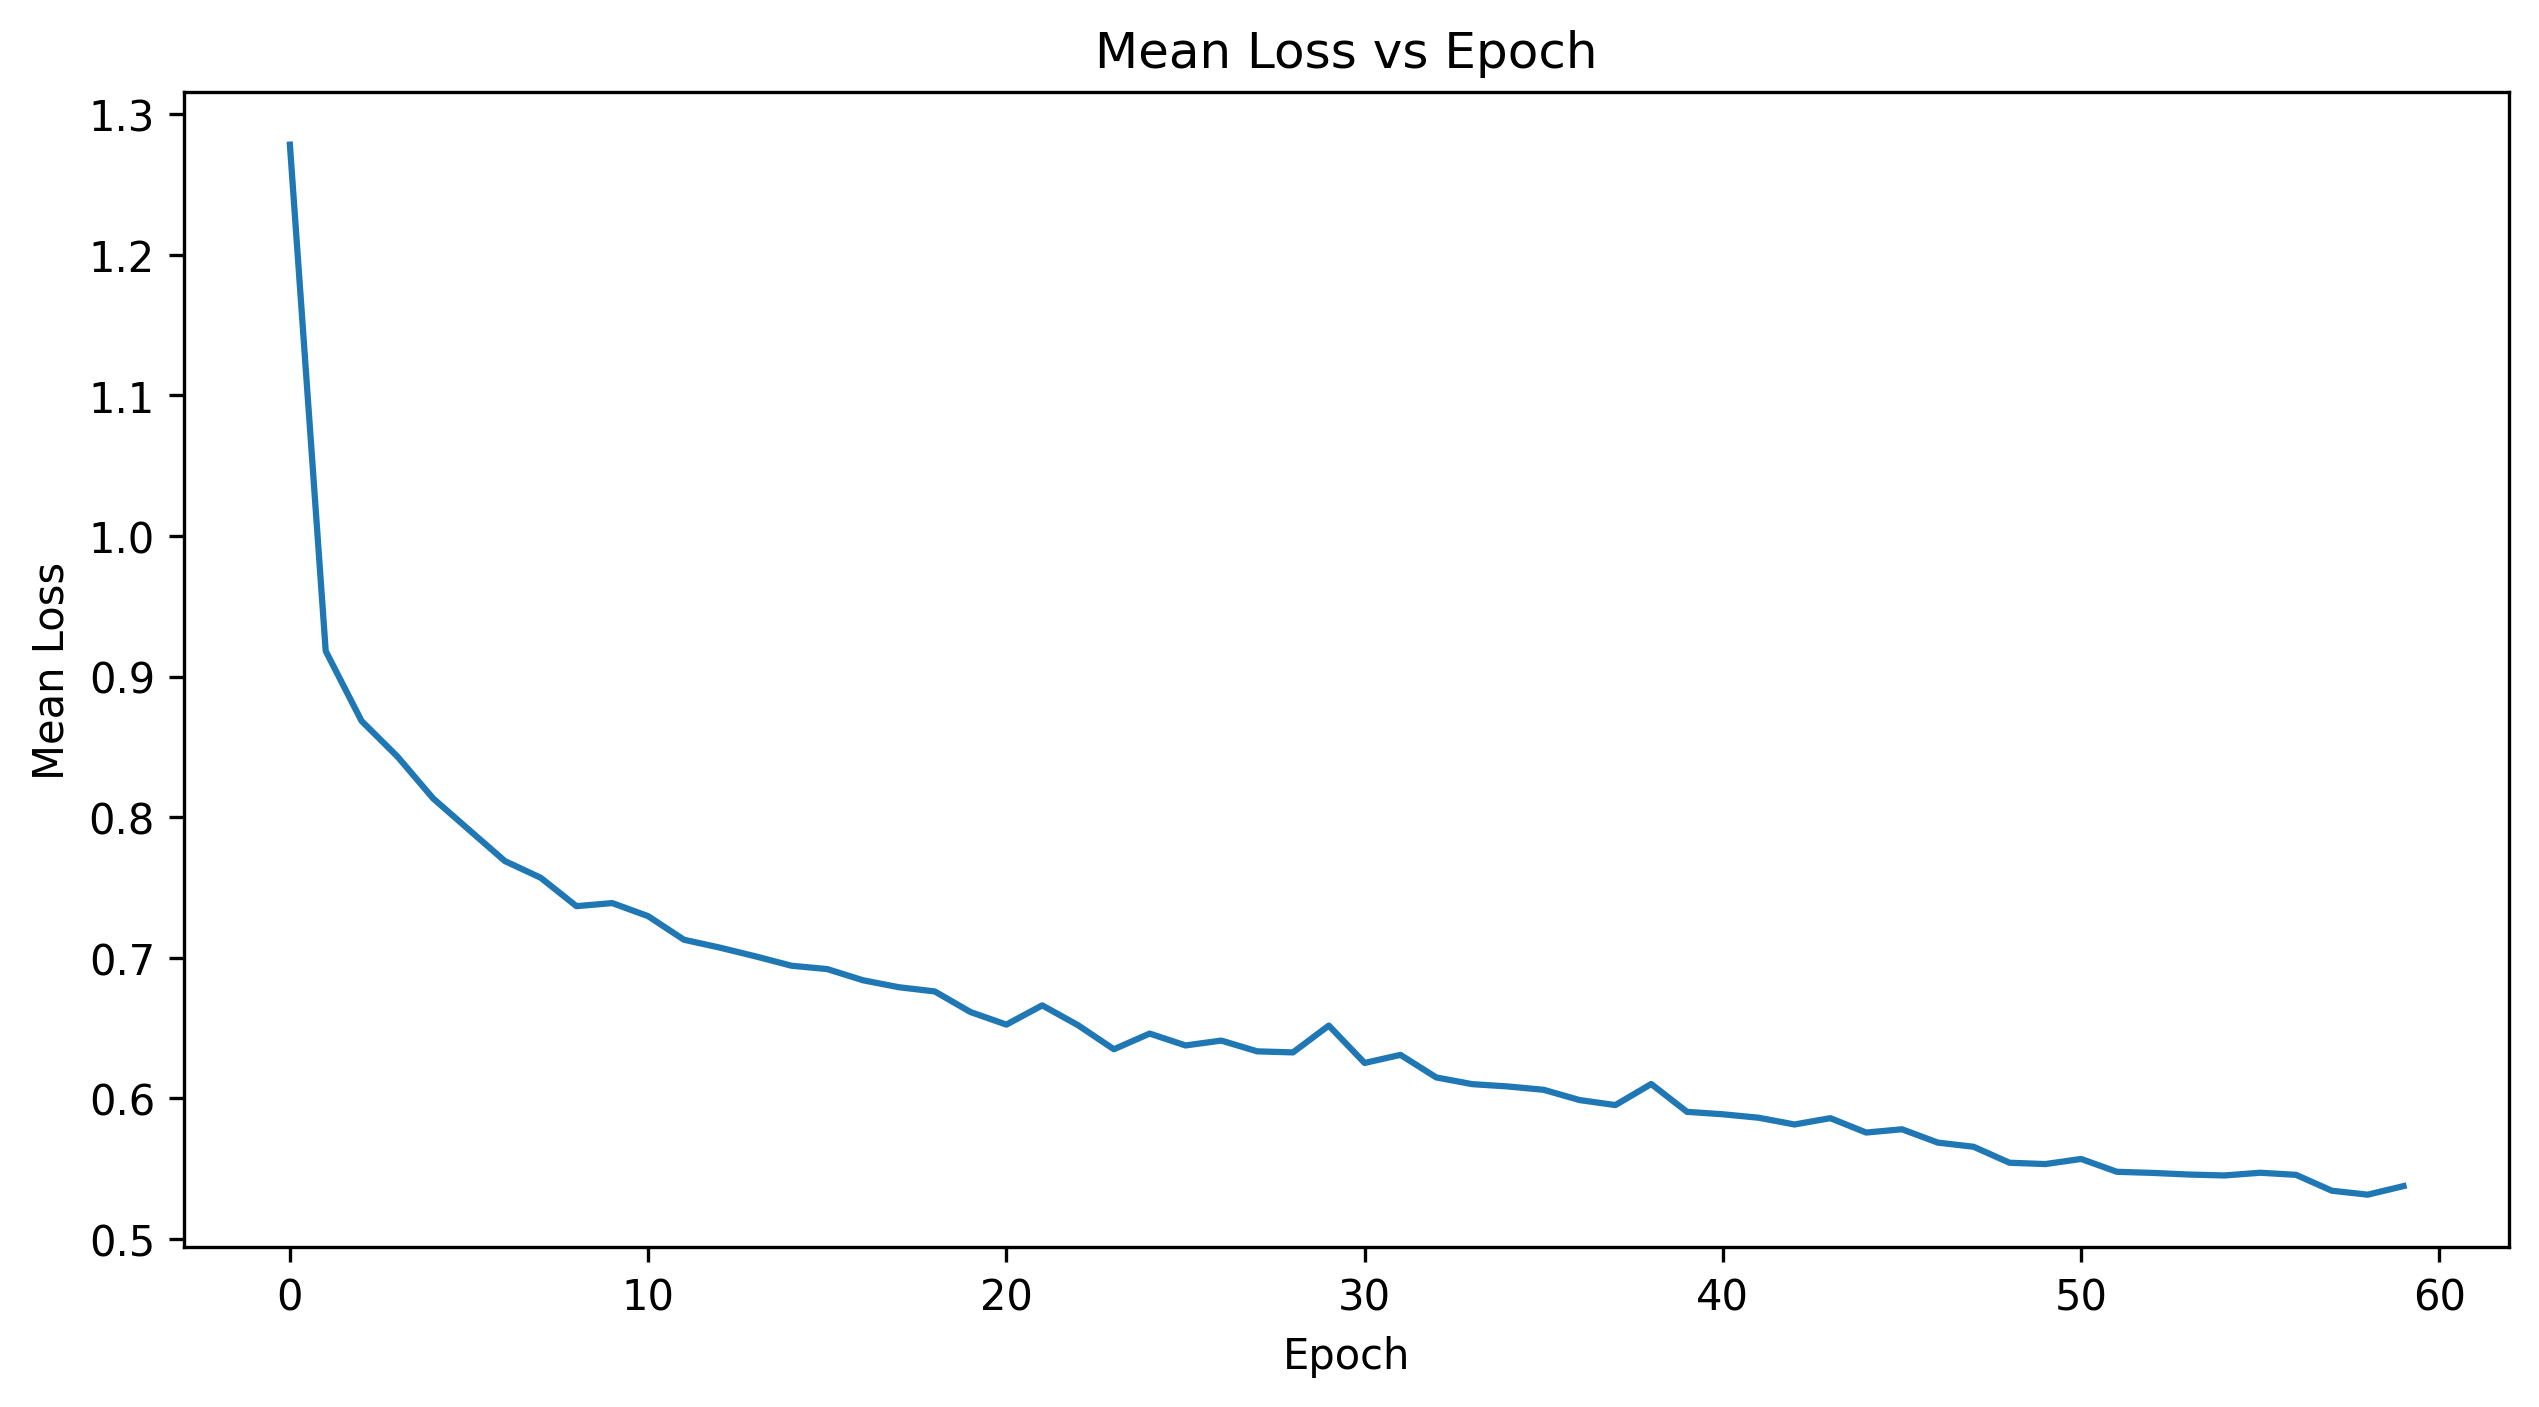

In [230]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

ax.plot(ave_meanloss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Loss")
ax.set_title("Mean Loss vs Epoch")